In [1]:
import math
import copy
import numpy as np
import matplotlib.pyplot as plt
import warnings

from collections import defaultdict

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import ParameterGrid, KFold, train_test_split

from numpy.random import default_rng

In [2]:
rng = default_rng()

def random_uniform(n,m,R=[-1.0,1.0]):
  a, b = R[0], R[1]
  return (b - a) * rng.random((n,m)) + a

def sigmoid(x):
  return 1.0 / (1.0 + np.exp(-x))

def deriv_sigmoid(x):
  return sigmoid(x) * (1.0 - sigmoid(x))

def squared_error(y_true,y_pred):
  return 0.5 * (y_true - y_pred) ** 2

def deriv_squared_error(y_true,y_pred):
  return y_pred - y_true

def indicator(p):
  return p.astype(int)

def error_rate(y_true, y_pred):
  return 1.0 - np.mean(indicator(y_true == y_pred))

def identity(x):
  return x

def deriv_identity(x):
  return np.ones(x.shape)

In [3]:
def make_nunits(n,K,L,N):
  nunits = [n]
  for l in range(L):
    nunits.append(N)
  nunits.append(K)
  return nunits

def time_nnet(nunits):
  t = 0
  for l in range(len(nunits)-1):
    t += (nunits[l] + 1) * nunits[l+1]
  return t

In [4]:
MAX_ITERS = 50
MAX_NHIDU = 2**9
MAX_NHIDL = 2**2
MAX_M = 2000

n=5 ##
K=5 ##

MAX_NUNITS = make_nunits(n,K,MAX_NHIDL,MAX_NHIDU)
MAX_NNET_TIME = time_nnet(MAX_NUNITS)

MAX_TIME = MAX_M * MAX_NNET_TIME * MAX_ITERS


In [5]:
print(MAX_ITERS)
print(MAX_NHIDU)
print(MAX_NHIDL)
print(MAX_M)
print(n)
print(K)
print(MAX_NUNITS)
print(MAX_NNET_TIME)
print(MAX_TIME)

50
512
4
2000
5
5
[5, 512, 512, 512, 512, 5]
793605
79360500000


In [6]:
class NNetBaseFunction:
    def __init__(self, f=None,df=None):
      self.f = f
      self.df = df 

    def deepcopy(self):
      return NNetBaseFunction(f=self.f, df=self.df) 

In [7]:
class NNetActivation(NNetBaseFunction):
    def __init__(self, f=sigmoid,df=deriv_sigmoid):
      super().__init__(f=f,df=df)

    def deepcopy(self):
      return NNetActivation(f=self.f, df=self.df) 

In [8]:
class NNetLoss(NNetBaseFunction):
  def __init__(self, f=squared_error,df=deriv_squared_error):
    super().__init__(f=f,df=df)

  def deepcopy(self):
    return NNetLoss(f=self.f, df=self.df)

In [9]:
class NNetMetric(NNetBaseFunction):
  def __init__(self, f=error_rate):
    super().__init__(f=f,df=None)

  def deepcopy(self):
    return NNetMetric(f=self.f)

In [10]:
class NNetLayer:
  def __init__(self,n_in=1,n_out=1,W=None,
               unit=NNetActivation(), initializer=random_uniform):
    self.n_in = n_in
    self.n_out = n_out
    if initializer is None:
      initializer =  lambda n, m : np.zeros((n,m))
    self.initializer = initializer
    if W is None:
      W = self.initializer(n_out,n_in+1)
    else: 
      self.n_in, self.n_out = W.shape[1]-1, W.shape[0]
    self.W = W
    self.unit = unit

  def ds(self, x):
    return self.unit.df(x)

  def deepcopy(self):
    return NNetLayer(n_in=self.n_in,n_out=self.n_out,W=self.W.copy(),
                     unit=self.unit)

  def copy_layer(self, layer):
    self.W[:] = layer.W[:]
    return self

  # assumes x[0,:] = +1
  def aggregation_with_dummy_input(self, x):
    return np.matmul(self.W,x)

  def aggregation(self, x):
    if x.shape[0] == self.W.shape[1]:
      x_tmp = x
    else: 
      x_tmp = np.ones(W.shape[1],x.shape[1])
      x_tmp[1:,:] = x
    return self.aggregation_with_dummy_input(x_tmp)

  def activation(self, x):
    return self.unit.f(self.aggregation(x))

  def set_x(self, x):
    return x

  def set_y(self, y):
    return y

  def get_y(self):
    return None
  

In [11]:
class NNetIdentityLayer (NNetLayer):
  def __init__(self,n_in=1,n_out=1,W=None):
    super().__init__(n_in=n_in,n_out=n_out,W=W,
                     unit=NNetActivation(identity,deriv_identity))

In [12]:
class NNetLayerProp(NNetLayer):
  def __init__(self,n_in=1,n_out=1,W=None,
               unit=NNetActivation(sigmoid,deriv_sigmoid),m=1):
    super().__init__(n_in=n_in,n_out=n_out,W=W,unit=unit)
    # self.y = np.ones((n_out+1,m))
    # self.y[1:,:] = 0
    # self.delta = np.zeros((n_out+1,m))
    self.x = None
    self.y = None
    self.delta = None

  def deepcopy(self):
    copy = super().deepcopy()
    # Input is not "stored" by layer
    copy.x = self.x
    copy.y = None if self.y is None else self.y.copy()
    copy.delta = None if self.delta is None else self.delta.copy()
    return copy

  def set_x(self, x):
    self.x = x
    return x

  def set_y(self, y):
    self.y = y
    return y

  def set_delta(self, delta):
    self.delta = delta
    return delta

  def get_x(self):
    return self.x

  def get_y(self):
    return self.y

  def get_delta(self):
    return self.delta

  def dW(self):
    return np.matmul(self.delta,self.x.T)

In [13]:
class NNetInputLayerProp(NNetLayerProp):
  def __init__(self,n_in=1,n_out=1,W=None,m=1):
    super().__init__(n_in=n_in,n_out=n_out,W=W,unit=NNetActivation(identity,deriv_identity))
    self.y = None

  def deepcopy(self):
    obj = super().deepcopy()
    obj.y = None if self.y is None else self.y.deepcopy()
    return obj


In [14]:
class NNetOptimizer:
  def __init__(self,loss=NNetLoss(),metric=NNetMetric()):
    self.loss = loss
    self.metric = metric
    self.best_nnet = None
    self.last_nnet = None
    self.train_err = []
    self.test_err = []
    return self

  def deepcopy(self):
    opt = NNetOptimizer(loss=self.loss.deepcopy(),metric=self.metric.deepcopy())
    opt.best_nnet = None if self.best_nnet is None else self.best_nnet.deepcopy()
    opt.last_nnet = None if self.best_nnet is None else self.last_nnet.deepcopy()
    opt.train_err = self.train_err.deepcopy()
    opt.test_err = self.test_err.deepcopy()
    return opt

  def run(self,nnet,X,y):
    return self.best_nnet

In [15]:
class NNet:
  def __init__(self, nunits=[0,0], unit=NNetActivation(sigmoid,deriv_sigmoid), 
               output_unit=None, Layer=NNetLayerProp, InputLayer=NNetInputLayerProp):
    self.nunits = nunits
    self.unit = unit
    self.output_unit = unit if output_unit is None else output_unit
    self.nlayers = len(nunits)
    self.layer = []
    self.layer.append(InputLayer(n_in=1,n_out=nunits[0]))

    for l in range(1,self.nlayers-1):
      self.layer.append(Layer(n_in=nunits[l-1],n_out=nunits[l],unit=unit))

    self.layer.append(Layer(n_in=nunits[-2],n_out=nunits[-1],
                                unit=self.output_unit))

  def copy(self, nnet_copy=None, Layer=NNetLayerProp, InputLayer=NNetInputLayerProp):
    if nnet_copy is None:
      nnet_copy = NNet(nunits=self.nunits,unit=self.unit,output_unit=self.output_unit, Layer=Layer, InputLayer=InputLayer)
    nnet_copy.copy_layers(self)
    return nnet_copy

  def deepcopy(self, nnet_copy=None):
    nnet_copy = self.copy(nnet_copy=nnet_copy)

    nnet_copy.nunits = copy.deepcopy(self.nunits)
    nnet_copy.unit = self.unit.deepcopy()
    nnet_copy.output_unit = self.output_unit.deepcopy()

    for l in range(1,self.nlayers):
      nnet_copy.layer[l] = self.layer[l].deepcopy()

    return nnet_copy

  def copy_layers(self, nnet_copy_from):
    for l in range(self.nlayers):
      self.layer[l].copy_layer(nnet_copy_from.layer[l])
    return self

  def error(self, X, y, loss=squared_error, metric=None):
    output = self.forwardprop(X.T)
    err = np.mean(loss(y.T, output))
    err_rate = 1.0 if metric is None else metric(y.T,output)
    return err, err_rate

  def forwardprop(self,X):
    m = X.shape[1]
    out_vals = np.ones((X.shape[0]+1,m))
    out_vals[1:,:] = X
    self.layer[0].set_y(out_vals)

    for l in range(1,self.nlayers):
      self.layer[l].set_x(self.layer[l-1].get_y())
      del out_vals
      out_vals = np.ones((self.nunits[l]+1,m))
      out_vals[1:,:] = self.layer[l].activation(self.layer[l].get_x())
      self.layer[l].set_y(out_vals)

    return out_vals[1:,:]

  def backprop(self,X,y,dE='deriv_squared_error'):
    net_output = self.forwardprop(X)

    layer = self.layer[self.nlayers-1]
    layer.set_delta(layer.ds(net_output) * dE(y,net_output))

    for l in range(self.nlayers-1,1,-1):
      next_layer = self.layer[l]
      layer = self.layer[l-1]
      x = layer.get_y()[1:,:]
      d = next_layer.delta
      layer.set_delta(layer.ds(x) * np.matmul(next_layer.W[:,1:].T,d))

    dW = []
    for l in range(self.nlayers):
      dW.append(None)

    for l in range(self.nlayers-1,0,-1):
      dW[l] = self.layer[l].dW() 

    return dW

  def fit(self, X, y, X_test=None, y_test=None, optimizer=None, verbose=0):
    if optimizer is None:
      optimizer = NNetGDOptimizer(loss=NNetLoss())

    best_nnet = optimizer.run(self,X,y,X_test,y_test,verbose)

    self.copy_layers(best_nnet)

    return self


In [16]:
class NNetGDOptimizer(NNetOptimizer):
  def __init__(self,loss=NNetLoss(),max_iters=100, learn_rate=1, reg_param=0, 
               change_thresh=1e-4, change_err_thresh=1e-6,metric=NNetMetric()):
    super().__init__(loss=loss,metric=metric)
    self.max_iters = max_iters
    self.learn_rate = learn_rate
    self.reg_param = reg_param
    self.change_thresh = change_thresh
    self.change_err_thresh = change_err_thresh

  def deepcopy(self):
    opt = super().deepcopy()
    return NNetGDOptimizer(loss=opt.loss, max_iters=self.max_iters, learn_rate=self.learn_rate, reg_param=self.reg_param, 
               change_thresh=self.change_thresh, change_err_thresh=self.change_err_thresh,metric=opt.metric)

  def run(self, nnet, X, y, X_test=None, y_test=None, verbose=0):

    eval_test = X_test is not None and y_test is not None
    new_nnet = NNet(nunits=nnet.nunits,unit=nnet.unit,output_unit=nnet.output_unit,Layer=NNetLayerProp,InputLayer=NNetInputLayerProp)
    new_nnet.copy_layers(nnet)

    t = 0
    max_change = math.inf
    min_change_err = math.inf

    train_err = []
    test_err = []

    err, err_rate = new_nnet.error(X, y, loss=self.loss.f, metric=self.metric.f)
    if verbose > 0:
      print((err,err_rate))
    min_err, min_err_rate = err, err_rate
 
    if eval_test:
      cv_err,cv_err_rate = new_nnet.error(X_test, y_test, loss=self.loss.f, metric=self.metric.f)

    best_nnet = nnet.deepcopy()
    best_nnet.copy_layers(new_nnet)

    while min_change_err > self.change_err_thresh and max_change > self.change_thresh and t < self.max_iters:
      if verbose > 0:
        print(t)
        print("Backprop...")

      dW = new_nnet.backprop(X.T, y.T,dE=self.loss.df)
      
      if verbose > 0:
        print("done.")
        print("Update...")

      max_change = 0

      for l in range(new_nnet.nlayers-1,0,-1):
        delta_W = self.learn_rate * (dW[l] / m + self.reg_param * new_nnet.layer[l].W)
        new_nnet.layer[l].W[:] = new_nnet.layer[l].W[:] - delta_W[:]
        max_change = max(max_change, np.max(np.absolute(delta_W)))

      del dW[:]

      if verbose > 0:
        print("done.")

      last_err = err
      err,err_rate = new_nnet.error(X, y, loss=self.loss.f, metric=self.metric.f)
      if verbose > 0:
        print((err,err_rate))
      min_change_err = np.absolute(err-last_err)


      if verbose > 0:
        print("max_change")
        print(max_change)

      if eval_test:
        cv_err,cv_err_rate = new_nnet.error(X_test, y_test, loss=self.loss.f, metric=self.metric.f)

      if verbose > 0:
        if eval_test:
          print("(test_err,test_err_rate)")
          print((cv_err,cv_err_rate))

      if err < min_err:
        min_err = err
        min_err_rate = err_rate
        best_nnet.copy_layers(new_nnet)

      t += 1

      train_err.append([err, err_rate])
      if eval_test:
        test_err.append([cv_err, cv_err_rate])

    if verbose > 0:
      if eval_test:
        print("(best_train_err,best_train_err_rate)")
        print((min_err,min_err_rate))

    self.train_err = train_err
    self.test_err = test_err

    return best_nnet

In [17]:
if __name__ == '__main__':
  D = np.loadtxt("optdigits_train.dat")
  D_test = np.loadtxt("optdigits_test.dat")
  D_trial = np.loadtxt("optdigits_trial.dat")

In [18]:
  m, n = D.shape[0], D.shape[1]-1

  X = D[:,:-1].reshape(m,n)
  y = D[:,-1].reshape(m,1)

  out_enc = LabelBinarizer()
  y_ohe = out_enc.fit_transform(y)

  K = y_ohe.shape[1]

  m_test = D_test.shape[0]

  X_test = D_test[:,:-1].reshape(m_test,n)
  y_test = D_test[:,-1].reshape(m_test,1)

  y_test_ohe = out_enc.transform(y_test)

  m_trial = D_test.shape[0]

  X_trial = D_test[:,:-1].reshape(m_trial,n)
  y_trial = D_test[:,-1].reshape(m_trial,1)

  y_trial_ohe = out_enc.transform(y_test)

[4.]


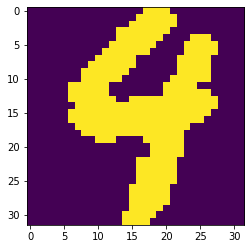

In [19]:
  plt.imshow(X[53,:].reshape(32,32))
  print(y[53])

[6.]


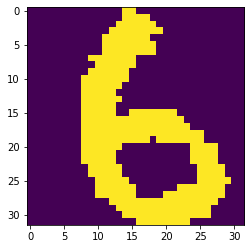

In [20]:
  plt.imshow(X_trial[1,:].reshape(32,32))
  print(y_trial[1])

In [21]:
  def nnet_error_rate(y_true, y_pred):
    y_pred_label = np.argmax(y_pred,axis=0).reshape(-1,1)
    y_true_label = out_enc.inverse_transform(y_true.T).reshape(-1,1)
    return error_rate(y_true_label, y_pred_label)  

In [22]:
  nnet_metric = NNetMetric(f=nnet_error_rate)

In [23]:
  print(n)
  print(K)
  print(m)
  print(m_test)

1024
10
1934
946


In [24]:
import numpy as np
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Dense

X=X
y=y_ohe

# Define the number of folds
num_folds = 3

# Define the K-fold cross-validator
kfold = KFold(n_splits=num_folds, shuffle=True)
n=1024
K=10

learn_rate=[1,4,4**2,4**3, 4**4]
# learn_rate=[4**4]

# Define the list to store the cross-validation scores
cvscores = []

for lr in learn_rate:
  # Loop through each fold
  for train, test in kfold.split(X, y):
      

      # print("CV  "+str(kfold.split))
      
      nnet = NNet(nunits=[n, K])

      opt = NNetGDOptimizer(metric=nnet_metric, max_iters=1000, learn_rate=lr)

      best_nnet = nnet.fit(X[train],y[train],X[test],y[test],optimizer=opt,verbose=0)

      train_err, test_err = np.array(opt.train_err), np.array(opt.test_err)


      print("learn rate "+ str(lr))
      print("train error "+ str(train_err[-1,1]))
      print("test error "+ str(test_err[-1,1]))

      
      # Fit the model to the training data
      # model.fit(X[train], y[train], epochs=150, batch_size=10, verbose=0)
      
      # Evaluate the model on the test data and store the accuracy score
  #     scores = best_nnet.evaluate(X[test], y[test], verbose=0)
  #     cvscores.append(scores[1] * 100)
      
  # # Print the mean and standard deviation of the cross-validation scores
  # print("Accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))


learn rate 1
train error 0.00853374709076804
test error 0.06666666666666665
learn rate 1
train error 0.006206361520558534
test error 0.07131782945736431
learn rate 1
train error 0.00852713178294573
test error 0.07608695652173914
learn rate 4
train error 0.0
test error 0.051162790697674376
learn rate 4
train error 0.0
test error 0.07751937984496127
learn rate 4
train error 0.0
test error 0.060559006211180155
learn rate 16
train error 0.005430566330488773
test error 0.06356589147286817
learn rate 16
train error 0.006206361520558534
test error 0.05736434108527133
learn rate 16
train error 0.0
test error 0.0357142857142857


c:\users\sourabh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  


learn rate 64
train error 0.0
test error 0.054263565891472854
learn rate 64
train error 0.003103180760279267
test error 0.058914728682170514
learn rate 64
train error 0.0
test error 0.045031055900621064
learn rate 256
train error 0.011636927851047307
test error 0.04961240310077519
learn rate 256
train error 0.0
test error 0.05271317829457367
learn rate 256
train error 0.0
test error 0.060559006211180155


In [25]:
test_err[-1,1]

0.060559006211180155

In [26]:
train_err[-1,1]

0.0

0.060559006211180155


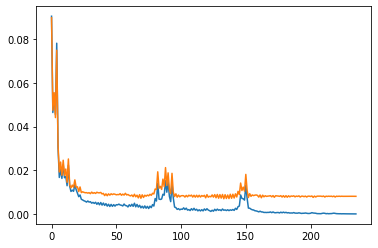

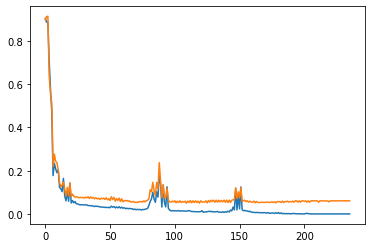

In [28]:
  # train_err, test_err = np.array(opt.train_err), np.array(opt.test_err)

  print(test_err[-1,1])

  plt.plot(train_err[:,0])
  plt.plot(test_err[:,0])
  plt.show()

  plt.plot(train_err[:,1])
  plt.plot(test_err[:,1])
  plt.show()

In [30]:
import numpy as np
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Dense

X=X
y=y_ohe

# Define the number of folds
num_folds = 3

# Define the K-fold cross-validator
kfold = KFold(n_splits=num_folds, shuffle=True)
n=1024
K=10
# n_hidl=[4**2,4**3,4**4]
# n_hidu=[4**2,4**3,4**4]
# n_hidl=[1,2,3,4]
# n_hidl=[1]
# n_hidu=[4**2]

# learn_rate=[4**-2,4**-1,4**0,4**1, 4**2]
learn_rate=[4**-2]

n_hidu = 16 # 512
n_hidl = 1

nunits = make_nunits(n,K,n_hidl,n_hidu)
nnet_time = time_nnet(nunits)

R = min(1000,math.ceil(MAX_TIME / (m * nnet_time)))

print(R)

1000


In [31]:
import numpy as np
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Dense

X=X
y=y_ohe

# Define the number of folds
num_folds = 3

# Define the K-fold cross-validator
kfold = KFold(n_splits=num_folds, shuffle=True)
n=1024
K=10
# n_hidl=[4**2,4**3,4**4]
# n_hidu=[4**2,4**3,4**4]
# n_hidl=[1,2,3,4]
# n_hidl=[1]
# n_hidu=[4**2]

learn_rate=[4**-2,4**-1,4**0,4**1, 4**2]
# learn_rate=[4**-2]

n_hidu = 64 # 512
n_hidl = 4

nunits = make_nunits(n,K,n_hidl,n_hidu)
nnet_time = time_nnet(nunits)

R = min(1000,math.ceil(MAX_TIME / (m * nnet_time)))

print(R)

# Define the list to store the cross-validation scores
cvscores = []

for lr in learn_rate:
  # for lr in learn_rate:
  # Loop through each fold
  for train, test in kfold.split(X, y):
      

      # print("CV  "+str(kfold.split))
      
      # nnet = NNet(nunits=[n, K])
      nnet = NNet(nunits=[n,n_hidl,n_hidu,K])

      opt = NNetGDOptimizer(metric=nnet_metric, max_iters=1000, learn_rate=lr)

      best_nnet = nnet.fit(X[train],y[train],X[test],y[test],optimizer=opt,verbose=0)

      train_err, test_err = np.array(opt.train_err), np.array(opt.test_err)


      print("learn rate "+str(lr))
      print("train error "+ str(train_err[-1,1]))
      print("test error "+ str(test_err[-1,1]))


522
learn rate 0.0625
train error 0.7245927075252133
test error 0.7379844961240309
learn rate 0.0625
train error 0.704422032583398
test error 0.7147286821705426
learn rate 0.0625
train error 0.6891472868217055
test error 0.718944099378882
learn rate 0.25
train error 0.6283941039565555
test error 0.6744186046511628
learn rate 0.25
train error 0.4732350659425911
test error 0.5364341085271318
learn rate 0.25
train error 0.5108527131782945
test error 0.531055900621118
learn rate 1
train error 0.3677269200930954
test error 0.3317829457364341


c:\users\sourabh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  


learn rate 1
train error 0.42513576415826226
test error 0.46976744186046515
learn rate 1
train error 0.4147286821705426
test error 0.4487577639751553
learn rate 4
train error 0.8875096974398758
test error 0.9038759689922481
learn rate 4
train error 0.5104732350659427
test error 0.524031007751938
learn rate 4
train error 0.32480620155038764
test error 0.3214285714285714
learn rate 16
train error 0.6268425135764158
test error 0.6713178294573643
learn rate 16
train error 0.42513576415826226
test error 0.43410852713178294
learn rate 16
train error 0.889922480620155
test error 0.9114906832298136


0.9114906832298136


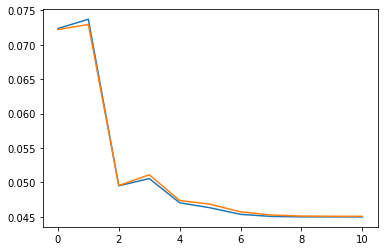

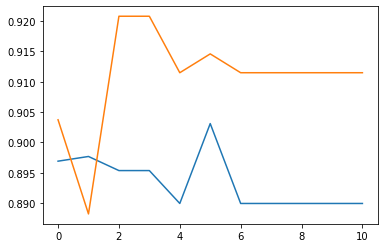

In [32]:
  # train_err, test_err = np.array(opt.train_err), np.array(opt.test_err)

  print(test_err[-1,1])

  plt.plot(train_err[:,0])
  plt.plot(test_err[:,0])
  plt.show()

  plt.plot(train_err[:,1])
  plt.plot(test_err[:,1])
  plt.show()

In [34]:
import numpy as np
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Dense

X=X
y=y_ohe

# Define the number of folds
num_folds = 3

# Define the K-fold cross-validator
kfold = KFold(n_splits=num_folds, shuffle=True)
n=1024
K=10
# n_hidl=[4**2,4**3,4**4]
# n_hidu=[4**2,4**3,4**4]
# n_hidl=[1,2,3,4]
# n_hidl=[1]
# n_hidu=[4**2]

learn_rate=[4**-3,4**-2,4**-1,4**0, 4**1]
# learn_rate=[4**-2]

n_hidu = 256 # 512
n_hidl = 2

nunits = make_nunits(n,K,n_hidl,n_hidu)
nnet_time = time_nnet(nunits)

R = min(1000,math.ceil(MAX_TIME / (m * nnet_time)))

print(R)

# Define the list to store the cross-validation scores
cvscores = []

for lr in learn_rate:
  # for lr in learn_rate:
  # Loop through each fold
  for train, test in kfold.split(X, y):
      

      # print("CV  "+str(kfold.split))
      
      # nnet = NNet(nunits=[n, K])
      nnet = NNet(nunits=[n,n_hidl,n_hidu,K])

      opt = NNetGDOptimizer(metric=nnet_metric, max_iters=250, learn_rate=lr)

      best_nnet = nnet.fit(X[train],y[train],X[test],y[test],optimizer=opt,verbose=0)

      train_err, test_err = np.array(opt.train_err), np.array(opt.test_err)


      print("learn rate "+str(lr))
      print("train error "+ str(train_err[-1,1]))
      print("test error "+ str(test_err[-1,1]))


125
learn rate 0.015625
train error 0.8968192397207138
test error 0.9317829457364342
learn rate 0.015625
train error 0.861132660977502
test error 0.8573643410852714
learn rate 0.015625
train error 0.9147286821705426
test error 0.9177018633540373
learn rate 0.0625
train error 0.7928626842513576
test error 0.7953488372093023
learn rate 0.0625
train error 0.8890612878200155
test error 0.9302325581395349
learn rate 0.0625
train error 0.748062015503876
test error 0.7515527950310559
learn rate 0.25
train error 0.8906128782001551
test error 0.9147286821705426
learn rate 0.25
train error 0.747866563227308
test error 0.7457364341085271
learn rate 0.25
train error 0.7310077519379845
test error 0.7562111801242236
learn rate 1
train error 0.6415826221877424
test error 0.6666666666666667
learn rate 1
train error 0.7168347556245152
test error 0.7348837209302326
learn rate 1
train error 0.6713178294573643
test error 0.6630434782608696


c:\users\sourabh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  


learn rate 4
train error 0.7315748642358417
test error 0.7627906976744185
learn rate 4
train error 0.7571761055081458
test error 0.7767441860465116
learn rate 4
train error 0.7612403100775194
test error 0.7546583850931677


0.7546583850931677


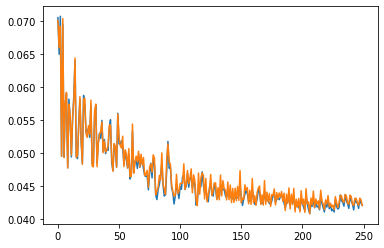

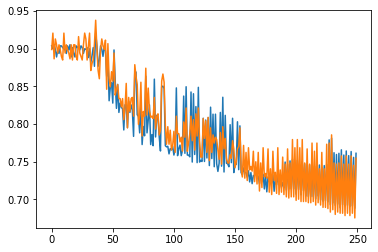

In [35]:
  # train_err, test_err = np.array(opt.train_err), np.array(opt.test_err)

  print(test_err[-1,1])

  plt.plot(train_err[:,0])
  plt.plot(test_err[:,0])
  plt.show()
  # plt.legend()

  plt.plot(train_err[:,1])
  plt.plot(test_err[:,1])
  plt.show()

In [36]:
  print(n)
  print(K)
  print(m)
  print(m_test)

  # nnet = NNet(nunits=[n,64,16, K])
  nnet = NNet(nunits=[n, K])

  # opt = NNetGDOptimizer(metric=nnet_metric, max_iters=1000, learn_rate=1e20)
  opt = NNetGDOptimizer(metric=nnet_metric, max_iters=1000, learn_rate=1)

  # best_nnet = nnet.fit(X[:1000,:],y_ohe[:1000,:],X_test,y_test_ohe,optimizer=opt,verbose=1)
  best_nnet = nnet.fit(X,y_ohe,X_test,y_test_ohe,optimizer=opt,verbose=1)

1024
10
1934
946
(0.2547330591153741, 0.9441571871768356)
0
Backprop...
done.
Update...
done.
(0.0545564985382429, 0.8293691830403309)
max_change
0.16374311204877776
(test_err,test_err_rate)
(0.05464975453335376, 0.8234672304439746)
1
Backprop...
done.
Update...
done.
(0.056243454792163076, 0.8179937952430196)
max_change
0.025697653765657438
(test_err,test_err_rate)
(0.05646095122889189, 0.8192389006342495)
2
Backprop...
done.
Update...
done.
(0.06086705928897007, 0.8040330920372285)
max_change
0.02522317058450673
(test_err,test_err_rate)
(0.06164025372043273, 0.8097251585623679)
3
Backprop...
done.
Update...
done.
(0.06530689463840438, 0.7781799379524302)
max_change
0.022763398276142818
(test_err,test_err_rate)
(0.0664241722379785, 0.7801268498942917)
4
Backprop...
done.
Update...
done.
(0.06375233567552174, 0.7357807652533609)
max_change
0.01801812262501852
(test_err,test_err_rate)
(0.06529800482221418, 0.7378435517970401)
5
Backprop...
done.
Update...
done.
(0.0598897575596033, 0.69

(0.017336936154124526, 0.16028955532574973)
max_change
0.0030485573331771646
(test_err,test_err_rate)
(0.020475410093211615, 0.19238900634249467)
51
Backprop...
done.
Update...
done.
(0.0171275666426566, 0.1592554291623578)
max_change
0.0029930699884806716
(test_err,test_err_rate)
(0.020265084424997193, 0.19027484143763218)
52
Backprop...
done.
Update...
done.
(0.016924784499563986, 0.15563598759048602)
max_change
0.0029395054620144816
(test_err,test_err_rate)
(0.020060957067939634, 0.18816067653276958)
53
Backprop...
done.
Update...
done.
(0.016728297231748398, 0.1530506721820062)
max_change
0.002887759501039636
(test_err,test_err_rate)
(0.019862711724145606, 0.18710359408033828)
54
Backprop...
done.
Update...
done.
(0.016537829232068, 0.14994829369183038)
max_change
0.002837734975073699
(test_err,test_err_rate)
(0.019670053077441182, 0.18498942917547567)
55
Backprop...
done.
Update...
done.
(0.01635312008239658, 0.14736297828335054)
max_change
0.0027893413499227664
(test_err,test_err

(0.01180627580650573, 0.09772492244053776)
max_change
0.0018323505839310688
(test_err,test_err_rate)
(0.01466833613938442, 0.13213530655391126)
96
Backprop...
done.
Update...
done.
(0.011734575404100039, 0.09772492244053776)
max_change
0.0018172399930152829
(test_err,test_err_rate)
(0.014591560214124928, 0.13107822410147996)
97
Backprop...
done.
Update...
done.
(0.011664079835612389, 0.09669079627714583)
max_change
0.0018023850891230391
(test_err,test_err_rate)
(0.014516178724234588, 0.12896405919661735)
98
Backprop...
done.
Update...
done.
(0.011594754935214557, 0.0956566701137539)
max_change
0.0017877783923570475
(test_err,test_err_rate)
(0.014442154807279891, 0.12790697674418605)
99
Backprop...
done.
Update...
done.
(0.011526567961611379, 0.09617373319544986)
max_change
0.0017734126558540152
(test_err,test_err_rate)
(0.014369452650031107, 0.12579281183932345)
100
Backprop...
done.
Update...
done.
(0.011459487521811145, 0.09513960703205793)
max_change
0.00175928086472
(test_err,test_

done.
Update...
done.
(0.009432025559152029, 0.07859358841778696)
max_change
0.001330326656382555
(test_err,test_err_rate)
(0.012198771322950252, 0.10570824524312894)
141
Backprop...
done.
Update...
done.
(0.009393217256814603, 0.078076525336091)
max_change
0.0013221086187661197
(test_err,test_err_rate)
(0.012159752154810872, 0.10570824524312894)
142
Backprop...
done.
Update...
done.
(0.009354826458257708, 0.07755946225439503)
max_change
0.0013139849368562742
(test_err,test_err_rate)
(0.012121197720164172, 0.10465116279069764)
143
Backprop...
done.
Update...
done.
(0.009316844604305966, 0.07704239917269906)
max_change
0.0013059542841678208
(test_err,test_err_rate)
(0.012083098437709407, 0.10465116279069764)
144
Backprop...
done.
Update...
done.
(0.0092792633530925, 0.07549120992761116)
max_change
0.0012980153621070024
(test_err,test_err_rate)
(0.012045445017077158, 0.10465116279069764)
145
Backprop...
done.
Update...
done.
(0.009242074575402864, 0.07497414684591519)
max_change
0.001290

done.
Update...
done.
(0.007927244207028762, 0.06566701137538777)
max_change
0.001138134491755381
(test_err,test_err_rate)
(0.010727735555841764, 0.09619450317124734)
189
Backprop...
done.
Update...
done.
(0.007901779523304639, 0.06566701137538777)
max_change
0.001135109062618516
(test_err,test_err_rate)
(0.010703803455038852, 0.09619450317124734)
190
Backprop...
done.
Update...
done.
(0.007876497389013963, 0.06463288521199584)
max_change
0.0011321001129908888
(test_err,test_err_rate)
(0.010680083598173, 0.09619450317124734)
191
Backprop...
done.
Update...
done.
(0.007851395372445192, 0.06463288521199584)
max_change
0.0011291073725567776
(test_err,test_err_rate)
(0.010656573286934255, 0.09619450317124734)
192
Backprop...
done.
Update...
done.
(0.007826471095782066, 0.06411582213029987)
max_change
0.001126130578504445
(test_err,test_err_rate)
(0.01063326987461262, 0.09619450317124734)
193
Backprop...
done.
Update...
done.
(0.007801722233149008, 0.0635987590486039)
max_change
0.001123169

done.
(0.006876715385900327, 0.05635987590486036)
max_change
0.0010079706351855333
(test_err,test_err_rate)
(0.009779514492977918, 0.08773784355179703)
237
Backprop...
done.
Update...
done.
(0.006857927717256825, 0.05635987590486036)
max_change
0.0010055268514985948
(test_err,test_err_rate)
(0.009763377276997061, 0.08773784355179703)
238
Backprop...
done.
Update...
done.
(0.006839244402716029, 0.05584281282316439)
max_change
0.001003092207869345
(test_err,test_err_rate)
(0.009747361383273347, 0.08773784355179703)
239
Backprop...
done.
Update...
done.
(0.006820664353473767, 0.05532574974146842)
max_change
0.0010006666302736745
(test_err,test_err_rate)
(0.00973146548836825, 0.08773784355179703)
240
Backprop...
done.
Update...
done.
(0.0068021864963766715, 0.054808686659772454)
max_change
0.000998250046660661
(test_err,test_err_rate)
(0.009715688285613885, 0.08773784355179703)
241
Backprop...
done.
Update...
done.
(0.006783809773751286, 0.05429162357807649)
max_change
0.000995842386901619

done.
Update...
done.
(0.0060765687996386245, 0.04912099276111681)
max_change
0.0009181558253238047
(test_err,test_err_rate)
(0.009121801432259385, 0.07399577167019022)
285
Backprop...
done.
Update...
done.
(0.006061802796144109, 0.04912099276111681)
max_change
0.0009167251880996348
(test_err,test_err_rate)
(0.009110245865733977, 0.07399577167019022)
286
Backprop...
done.
Update...
done.
(0.006047103873285179, 0.04860392967942084)
max_change
0.000915297729712404
(test_err,test_err_rate)
(0.009098763651800887, 0.07399577167019022)
287
Backprop...
done.
Update...
done.
(0.00603247151648451, 0.048086866597724875)
max_change
0.0009138734457870628
(test_err,test_err_rate)
(0.00908735406386577, 0.07399577167019022)
288
Backprop...
done.
Update...
done.
(0.006017905218893115, 0.048086866597724875)
max_change
0.000912452332478068
(test_err,test_err_rate)
(0.009076016384144167, 0.07399577167019022)
289
Backprop...
done.
Update...
done.
(0.0060034044812053815, 0.048086866597724875)
max_change
0.

(0.0054478523535442126, 0.043950361944157135)
max_change
0.0008543264012216742
(test_err,test_err_rate)
(0.008647625150477699, 0.07505285412262153)
332
Backprop...
done.
Update...
done.
(0.005435778382254302, 0.043950361944157135)
max_change
0.0008530436021898557
(test_err,test_err_rate)
(0.008638857804911604, 0.07505285412262153)
333
Backprop...
done.
Update...
done.
(0.0054237530635406215, 0.043950361944157135)
max_change
0.0008517638969769635
(test_err,test_err_rate)
(0.008630137726647537, 0.07505285412262153)
334
Backprop...
done.
Update...
done.
(0.005411776086423129, 0.043950361944157135)
max_change
0.0008504872803691471
(test_err,test_err_rate)
(0.008621464512254927, 0.07505285412262153)
335
Backprop...
done.
Update...
done.
(0.005399847141958259, 0.043950361944157135)
max_change
0.000849213746912726
(test_err,test_err_rate)
(0.00861283776360878, 0.07505285412262153)
336
Backprop...
done.
Update...
done.
(0.005387965923198333, 0.043950361944157135)
max_change
0.00084794329091589

done.
Update...
done.
(0.004918155490106422, 0.0382626680455016)
max_change
0.0007961108155668093
(test_err,test_err_rate)
(0.008274066170401523, 0.07082452431289643)
380
Backprop...
done.
Update...
done.
(0.004908096772840266, 0.0382626680455016)
max_change
0.000794967193820914
(test_err,test_err_rate)
(0.008267193119211601, 0.07082452431289643)
381
Backprop...
done.
Update...
done.
(0.004898073733681964, 0.0382626680455016)
max_change
0.0007938262125226117
(test_err,test_err_rate)
(0.008260352953322222, 0.07082452431289643)
382
Backprop...
done.
Update...
done.
(0.00488808614189652, 0.0382626680455016)
max_change
0.0007926878597128653
(test_err,test_err_rate)
(0.00825354545843099, 0.07082452431289643)
383
Backprop...
done.
Update...
done.
(0.004878133768337496, 0.0382626680455016)
max_change
0.0007915521234095866
(test_err,test_err_rate)
(0.008246770422770501, 0.07082452431289643)
384
Backprop...
done.
Update...
done.
(0.004868216385445854, 0.037745604963805635)
max_change
0.00079041

done.
Update...
done.
(0.004471895986717594, 0.033609100310237894)
max_change
0.0007439897810373613
(test_err,test_err_rate)
(0.007977960668897954, 0.06659619450317122)
428
Backprop...
done.
Update...
done.
(0.004463316487072326, 0.033609100310237894)
max_change
0.0007429596333603705
(test_err,test_err_rate)
(0.007972459347172915, 0.06659619450317122)
429
Backprop...
done.
Update...
done.
(0.004454763328193824, 0.033609100310237894)
max_change
0.0007419315776225036
(test_err,test_err_rate)
(0.007966982728883642, 0.06659619450317122)
430
Backprop...
done.
Update...
done.
(0.004446236351516402, 0.033609100310237894)
max_change
0.0007409056037327892
(test_err,test_err_rate)
(0.00796153067593383, 0.06659619450317122)
431
Backprop...
done.
Update...
done.
(0.004437735399854176, 0.033092037228541926)
max_change
0.0007398817016731051
(test_err,test_err_rate)
(0.007956103051144038, 0.06659619450317122)
432
Backprop...
done.
Update...
done.
(0.00442926031739569, 0.033092037228541926)
max_change

(test_err,test_err_rate)
(0.007757554717755405, 0.060253699788583526)
472
Backprop...
done.
Update...
done.
(0.004109844954781063, 0.031023784901758056)
max_change
0.0006995719249179112
(test_err,test_err_rate)
(0.007753020340241419, 0.060253699788583526)
473
Backprop...
done.
Update...
done.
(0.004102312602539429, 0.031023784901758056)
max_change
0.00069862696446561
(test_err,test_err_rate)
(0.007748505321329552, 0.060253699788583526)
474
Backprop...
done.
Update...
done.
(0.004094800746356479, 0.031023784901758056)
max_change
0.0006976837136957881
(test_err,test_err_rate)
(0.007744009554768729, 0.060253699788583526)
475
Backprop...
done.
Update...
done.
(0.004087309284421424, 0.031023784901758056)
max_change
0.0006967421656840826
(test_err,test_err_rate)
(0.007739532934923082, 0.060253699788583526)
476
Backprop...
done.
Update...
done.
(0.004079838116046661, 0.031023784901758056)
max_change
0.0006958023135669044
(test_err,test_err_rate)
(0.007735075356769537, 0.060253699788583526)
47

done.
Update...
done.
(0.00378989284907064, 0.028438469493278218)
max_change
0.0006586512997412354
(test_err,test_err_rate)
(0.007567493943781647, 0.059196617336152224)
518
Backprop...
done.
Update...
done.
(0.003783196715159078, 0.028438469493278218)
max_change
0.0006577771849246183
(test_err,test_err_rate)
(0.007563749068872546, 0.059196617336152224)
519
Backprop...
done.
Update...
done.
(0.0037765174846656436, 0.028438469493278218)
max_change
0.0006569045189406181
(test_err,test_err_rate)
(0.007560019268246504, 0.059196617336152224)
520
Backprop...
done.
Update...
done.
(0.0037698550972777543, 0.028438469493278218)
max_change
0.0006560332969275363
(test_err,test_err_rate)
(0.007556304461662825, 0.059196617336152224)
521
Backprop...
done.
Update...
done.
(0.00376320949335717, 0.028438469493278218)
max_change
0.0006551635140529153
(test_err,test_err_rate)
(0.007552604569391477, 0.059196617336152224)
522
Backprop...
done.
Update...
done.
(0.003756580613928078, 0.028438469493278218)
max

done.
Update...
done.
(0.0034985440030444997, 0.02792140641158225)
max_change
0.0006198716149816175
(test_err,test_err_rate)
(0.007409693142134166, 0.05708245243128962)
564
Backprop...
done.
Update...
done.
(0.003492571319883964, 0.02792140641158225)
max_change
0.0006190594523464454
(test_err,test_err_rate)
(0.007406565941471796, 0.05708245243128962)
565
Backprop...
done.
Update...
done.
(0.003486613287200204, 0.02792140641158225)
max_change
0.0006182485357409134
(test_err,test_err_rate)
(0.007403450610744898, 0.05708245243128962)
566
Backprop...
done.
Update...
done.
(0.0034806698639634915, 0.02792140641158225)
max_change
0.0006174388610619025
(test_err,test_err_rate)
(0.0074003470903172466, 0.05708245243128962)
567
Backprop...
done.
Update...
done.
(0.003474741009331335, 0.02792140641158225)
max_change
0.0006166304242152007
(test_err,test_err_rate)
(0.007397255320932698, 0.05708245243128962)
568
Backprop...
done.
Update...
done.
(0.003468826682640919, 0.02792140641158225)
max_change


(0.0032330235288460575, 0.024301964839710477)
max_change
0.0005829822084347258
(test_err,test_err_rate)
(0.007274642507271218, 0.05602536997885832)
611
Backprop...
done.
Update...
done.
(0.0032276970330643528, 0.024301964839710477)
max_change
0.0005822243492239287
(test_err,test_err_rate)
(0.007272014380737313, 0.05602536997885832)
612
Backprop...
done.
Update...
done.
(0.003222383371666877, 0.024301964839710477)
max_change
0.000581467556317238
(test_err,test_err_rate)
(0.007269395686133666, 0.05602536997885832)
613
Backprop...
done.
Update...
done.
(0.0032170825071754137, 0.024301964839710477)
max_change
0.0005807118263301839
(test_err,test_err_rate)
(0.007266786378662692, 0.05602536997885832)
614
Backprop...
done.
Update...
done.
(0.003211794402133548, 0.024301964839710477)
max_change
0.0005799571559050539
(test_err,test_err_rate)
(0.007264186413779428, 0.05602536997885832)
615
Backprop...
done.
Update...
done.
(0.0032065190191067306, 0.024301964839710477)
max_change
0.00057920354171

(test_err,test_err_rate)
(0.007167366094393227, 0.05496828752642702)
655
Backprop...
done.
Update...
done.
(0.0030055094527966755, 0.020165460186142736)
max_change
0.0005571700232776871
(test_err,test_err_rate)
(0.007165113638679614, 0.05496828752642702)
656
Backprop...
done.
Update...
done.
(0.0030007238180442984, 0.020165460186142736)
max_change
0.0005567144520470386
(test_err,test_err_rate)
(0.007162868854043319, 0.05496828752642702)
657
Backprop...
done.
Update...
done.
(0.002995949364918984, 0.020165460186142736)
max_change
0.0005562586642520972
(test_err,test_err_rate)
(0.007160631704829225, 0.05496828752642702)
658
Backprop...
done.
Update...
done.
(0.002991186057959904, 0.020165460186142736)
max_change
0.0005558026613589051
(test_err,test_err_rate)
(0.007158402155550677, 0.05496828752642702)
659
Backprop...
done.
Update...
done.
(0.0029864338617875065, 0.020165460186142736)
max_change
0.0005553464448068704
(test_err,test_err_rate)
(0.00715618017088811, 0.05496828752642702)
660


700
Backprop...
done.
Update...
done.
(0.002800736471345439, 0.01706308169596693)
max_change
0.000536472254048563
(test_err,test_err_rate)
(0.007071177258795283, 0.05496828752642702)
701
Backprop...
done.
Update...
done.
(0.002796420275889188, 0.016028955532574996)
max_change
0.0005360080720706433
(test_err,test_err_rate)
(0.007069243131825659, 0.05496828752642702)
702
Backprop...
done.
Update...
done.
(0.002792113766636578, 0.016028955532574996)
max_change
0.0005355437189859959
(test_err,test_err_rate)
(0.00706731519275142, 0.05496828752642702)
703
Backprop...
done.
Update...
done.
(0.0027878169130468116, 0.016028955532574996)
max_change
0.0005350791954721159
(test_err,test_err_rate)
(0.007065393412560616, 0.05496828752642702)
704
Backprop...
done.
Update...
done.
(0.002783529684706163, 0.016028955532574996)
max_change
0.0005346145021985485
(test_err,test_err_rate)
(0.007063477762367325, 0.05496828752642702)
705
Backprop...
done.
Update...
done.
(0.002779252051328191, 0.01602895553257

done.
(0.0026078735443796678, 0.01499482936918306)
max_change
0.000514480892674947
(test_err,test_err_rate)
(0.006986513737433661, 0.05391120507399583)
748
Backprop...
done.
Update...
done.
(0.0026039816420982687, 0.01499482936918306)
max_change
0.0005140093405771991
(test_err,test_err_rate)
(0.006984841041915219, 0.05391120507399583)
749
Backprop...
done.
Update...
done.
(0.002600098126616398, 0.01499482936918306)
max_change
0.0005135376468028762
(test_err,test_err_rate)
(0.006983173299871143, 0.05391120507399583)
750
Backprop...
done.
Update...
done.
(0.002596222973176263, 0.01499482936918306)
max_change
0.0005130658120626077
(test_err,test_err_rate)
(0.006981510487768146, 0.05391120507399583)
751
Backprop...
done.
Update...
done.
(0.0025923561571313007, 0.01499482936918306)
max_change
0.0005125938370762615
(test_err,test_err_rate)
(0.006979852582181605, 0.05391120507399583)
752
Backprop...
done.
Update...
done.
(0.0025884976539454606, 0.01499482936918306)
max_change
0.00051212172257

done.
(0.00242659920958336, 0.014477766287487093)
max_change
0.0004912238575010522
(test_err,test_err_rate)
(0.006909965821439446, 0.052854122621564525)
797
Backprop...
done.
Update...
done.
(0.002423091035172259, 0.014477766287487093)
max_change
0.0004907464327014105
(test_err,test_err_rate)
(0.006908510109349031, 0.052854122621564525)
798
Backprop...
done.
Update...
done.
(0.0024195901513182926, 0.014477766287487093)
max_change
0.0004902689173145266
(test_err,test_err_rate)
(0.006907058319761656, 0.052854122621564525)
799
Backprop...
done.
Update...
done.
(0.0024160965378257153, 0.014477766287487093)
max_change
0.0004897913128341433
(test_err,test_err_rate)
(0.006905610434098806, 0.052854122621564525)
800
Backprop...
done.
Update...
done.
(0.002412610174573682, 0.014477766287487093)
max_change
0.0004893136207754547
(test_err,test_err_rate)
(0.006904166433874292, 0.052854122621564525)
801
Backprop...
done.
Update...
done.
(0.002409131041515602, 0.014477766287487093)
max_change
0.00048

done.
Update...
done.
(0.002269281111243188, 0.013443640124095158)
max_change
0.0004687152144056135
(test_err,test_err_rate)
(0.006845502169403293, 0.052854122621564525)
844
Backprop...
done.
Update...
done.
(0.002266094876642411, 0.013443640124095158)
max_change
0.00046823551552114916
(test_err,test_err_rate)
(0.006844212155528486, 0.052854122621564525)
845
Backprop...
done.
Update...
done.
(0.0022629150557452902, 0.013443640124095158)
max_change
0.00046775582106019925
(test_err,test_err_rate)
(0.006842925284096003, 0.052854122621564525)
846
Backprop...
done.
Update...
done.
(0.0022597416313477705, 0.013443640124095158)
max_change
0.0004672761336027103
(test_err,test_err_rate)
(0.006841641540419772, 0.052854122621564525)
847
Backprop...
done.
Update...
done.
(0.0022565745863018243, 0.013443640124095158)
max_change
0.00046679645575093206
(test_err,test_err_rate)
(0.006840360909886634, 0.052854122621564525)
848
Backprop...
done.
Update...
done.
(0.0022534139035153195, 0.0134436401240951

done.
Update...
done.
(0.0021261922270512236, 0.011375387797311287)
max_change
0.000446219706944026
(test_err,test_err_rate)
(0.006788042798477995, 0.05391120507399583)
891
Backprop...
done.
Update...
done.
(0.0021232897380830304, 0.011375387797311287)
max_change
0.00044574333511796974
(test_err,test_err_rate)
(0.006786885720793993, 0.05391120507399583)
892
Backprop...
done.
Update...
done.
(0.002120392914253436, 0.011375387797311287)
max_change
0.00044526710998678975
(test_err,test_err_rate)
(0.006785731168331689, 0.05391120507399583)
893
Backprop...
done.
Update...
done.
(0.0021175017409863564, 0.011375387797311287)
max_change
0.0004447910349480121
(test_err,test_err_rate)
(0.006784579129461318, 0.05391120507399583)
894
Backprop...
done.
Update...
done.
(0.002114616203763659, 0.011375387797311287)
max_change
0.0004443151134095096
(test_err,test_err_rate)
(0.006783429592611326, 0.05391120507399583)
895
Backprop...
done.
Update...
done.
(0.002111736288125278, 0.011375387797311287)
max_

done.
Update...
done.
(0.0019956733795538978, 0.009824198552223384)
max_change
0.0004240451869994131
(test_err,test_err_rate)
(0.006736211413812735, 0.05391120507399583)
938
Backprop...
done.
Update...
done.
(0.0019930223488018946, 0.009824198552223384)
max_change
0.00042357948497255587
(test_err,test_err_rate)
(0.006735161359078376, 0.05391120507399583)
939
Backprop...
done.
Update...
done.
(0.0019903763617376284, 0.009824198552223384)
max_change
0.000423114094514407
(test_err,test_err_rate)
(0.006734113342850409, 0.05391120507399583)
940
Backprop...
done.
Update...
done.
(0.0019877354065400907, 0.009824198552223384)
max_change
0.00042264901910536804
(test_err,test_err_rate)
(0.006733067356042227, 0.05391120507399583)
941
Backprop...
done.
Update...
done.
(0.0019850994714442132, 0.009824198552223384)
max_change
0.00042218426221856786
(test_err,test_err_rate)
(0.0067320233896177644, 0.05391120507399583)
942
Backprop...
done.
Update...
done.
(0.0019824685447405793, 0.009824198552223384)

done.
(0.0018763448953506181, 0.009307135470527417)
max_change
0.0004025486110746788
(test_err,test_err_rate)
(0.0066889239266285806, 0.05391120507399583)
985
Backprop...
done.
Update...
done.
(0.0018739189779639316, 0.009307135470527417)
max_change
0.0004021011371723147
(test_err,test_err_rate)
(0.006687960653212097, 0.05391120507399583)
986
Backprop...
done.
Update...
done.
(0.0018714976025659136, 0.009307135470527417)
max_change
0.0004016541252323938
(test_err,test_err_rate)
(0.006686999043510539, 0.05391120507399583)
987
Backprop...
done.
Update...
done.
(0.001869080759490535, 0.009307135470527417)
max_change
0.0004012075780537468
(test_err,test_err_rate)
(0.006686039090649778, 0.05391120507399583)
988
Backprop...
done.
Update...
done.
(0.0018666684391045794, 0.009307135470527417)
max_change
0.00040076149841444586
(test_err,test_err_rate)
(0.006685080787798577, 0.05391120507399583)
989
Backprop...
done.
Update...
done.
(0.001864260631807062, 0.009307135470527417)
max_change
0.00040

0.05391120507399583


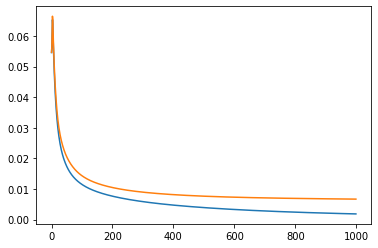

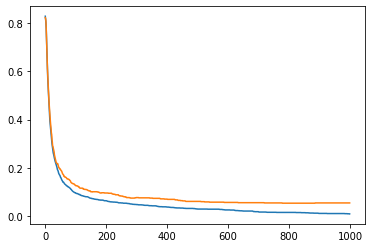

In [37]:
  train_err, test_err = np.array(opt.train_err), np.array(opt.test_err)

  print(test_err[-1,1])

  plt.plot(train_err[:,0])
  plt.plot(test_err[:,0])
  plt.show()

  plt.plot(train_err[:,1])
  plt.plot(test_err[:,1])
  plt.show()

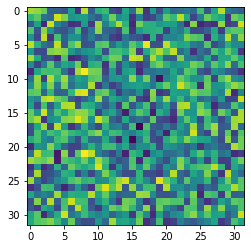

In [38]:
  plt.imshow(best_nnet.layer[1].W[0,1:].reshape(32,32))

In [39]:
  n_hidu = 64 # 512
  n_hidl = 4

  nunits = make_nunits(n,K,n_hidl,n_hidu)
  nnet_time = time_nnet(nunits)

  R = min(1000,math.ceil(MAX_TIME / (m * nnet_time)))

  print(R)

522


In [40]:
  print(n)
  print(K)
  print(m)
  print(m_test)

1024
10
1934
946


In [41]:
  # opt = NNetGDOptimizer(metric=nnet_metric, max_iters=400, learn_rate=0.5**8)
  opt = NNetGDOptimizer(metric=nnet_metric, max_iters=R, learn_rate=2**-1, change_err_thresh=0, change_thresh=0)

  # nnet = NNet(nunits=[1024, 512, 512, 10],unit=NNetActivation(identity,deriv_identity),output_unit=NNetActivation(sigmoid,deriv_sigmoid))
  nnet = NNet(nunits=nunits)

  best_nnet = nnet.fit(X,y_ohe,X_test,y_test_ohe,optimizer=opt,verbose=1)
  # est_nnet = nnet.fit(X,y_ohe,optimizer=opt,verbose=1)

(0.12840862337665998, 0.9027921406411582)
0
Backprop...
done.
Update...
done.
(0.053886535393810144, 0.8981385729058945)
max_change
0.08755388880493452
(test_err,test_err_rate)
(0.05403374131307844, 0.879492600422833)
1
Backprop...
done.
Update...
done.
(0.04623100203731776, 0.9002068252326784)
max_change
0.03008682911739172
(test_err,test_err_rate)
(0.04623481701725756, 0.8816067653276956)
2
Backprop...
done.
Update...
done.
(0.04553537464019711, 0.8888314374353671)
max_change
0.010170455098771196
(test_err,test_err_rate)
(0.04553779789332197, 0.8805496828752643)
3
Backprop...
done.
Update...
done.
(0.04518033830534999, 0.8867631851085832)
max_change
0.008284340076654623
(test_err,test_err_rate)
(0.04517984036729433, 0.8784355179704016)
4
Backprop...
done.
Update...
done.
(0.044944841337077726, 0.8743536711478801)
max_change
0.007565921732033808
(test_err,test_err_rate)
(0.044944423667616196, 0.872093023255814)
5
Backprop...
done.
Update...
done.
(0.044770209432201356, 0.8660806618407

done.
Update...
done.
(0.0374714608790465, 0.4343329886246122)
max_change
0.00686527251345602
(test_err,test_err_rate)
(0.03805512326865046, 0.4693446088794926)
48
Backprop...
done.
Update...
done.
(0.037254345922429176, 0.4234746639089969)
max_change
0.0068936728457741365
(test_err,test_err_rate)
(0.03785658478090845, 0.4640591966173362)
49
Backprop...
done.
Update...
done.
(0.03703746603027582, 0.4188210961737332)
max_change
0.006921236153771738
(test_err,test_err_rate)
(0.03765580653226545, 0.459830866807611)
50
Backprop...
done.
Update...
done.
(0.036821303870691525, 0.4126163391933816)
max_change
0.006948032467370284
(test_err,test_err_rate)
(0.037452701013445194, 0.4513742071881607)
51
Backprop...
done.
Update...
done.
(0.03660613935193688, 0.4043433298862461)
max_change
0.006994569542269281
(test_err,test_err_rate)
(0.03724711595012854, 0.4397463002114165)
52
Backprop...
done.
Update...
done.
(0.036392021496532284, 0.3996897621509824)
max_change
0.007040510173260816
(test_err,te

done.
Update...
done.
(0.02744779256921096, 0.23061013443640122)
max_change
0.0082219863072779
(test_err,test_err_rate)
(0.028353327124182, 0.2610993657505285)
96
Backprop...
done.
Update...
done.
(0.027264731920116626, 0.22699069286452944)
max_change
0.008240377837637074
(test_err,test_err_rate)
(0.028169027171007582, 0.2536997885835095)
97
Backprop...
done.
Update...
done.
(0.02708324891660061, 0.22699069286452944)
max_change
0.008257995675704791
(test_err,test_err_rate)
(0.02798560032060003, 0.2505285412262156)
98
Backprop...
done.
Update...
done.
(0.02690333384075829, 0.22647362978283347)
max_change
0.00827486683711043
(test_err,test_err_rate)
(0.027803310393729574, 0.2484143763213531)
99
Backprop...
done.
Update...
done.
(0.026724999347762582, 0.2244053774560496)
max_change
0.008291049825934243
(test_err,test_err_rate)
(0.027622304625330156, 0.2463002114164905)
100
Backprop...
done.
Update...
done.
(0.02654826861264434, 0.2213029989658738)
max_change
0.008306631344326678
(test_err

done.
Update...
done.
(0.02070255083228622, 0.16442605997931747)
max_change
0.008496429067144389
(test_err,test_err_rate)
(0.021531417554470803, 0.19344608879492597)
142
Backprop...
done.
Update...
done.
(0.0205916024224182, 0.16442605997931747)
max_change
0.00848660365093179
(test_err,test_err_rate)
(0.021415311310229813, 0.18921775898520088)
143
Backprop...
done.
Update...
done.
(0.02048186521568344, 0.16184074457083764)
max_change
0.00847614605439607
(test_err,test_err_rate)
(0.021300196598997408, 0.18710359408033828)
144
Backprop...
done.
Update...
done.
(0.02037329415578644, 0.16028955532574973)
max_change
0.008483660931616906
(test_err,test_err_rate)
(0.021186122952260175, 0.18816067653276958)
145
Backprop...
done.
Update...
done.
(0.02026584403012438, 0.15873836608066183)
max_change
0.00849344078987799
(test_err,test_err_rate)
(0.021073141416597312, 0.18604651162790697)
146
Backprop...
done.
Update...
done.
(0.02015946829216583, 0.1577042399172699)
max_change
0.00850238020773471

done.
Update...
done.
(0.016538359287273933, 0.13443640124095135)
max_change
0.008141921590492719
(test_err,test_err_rate)
(0.01714954174228307, 0.15010570824524316)
189
Backprop...
done.
Update...
done.
(0.01647398406462244, 0.1354705274043433)
max_change
0.008134228043044714
(test_err,test_err_rate)
(0.01707936709774184, 0.15010570824524316)
190
Backprop...
done.
Update...
done.
(0.016410421691529998, 0.13495346432264732)
max_change
0.008128347642970763
(test_err,test_err_rate)
(0.017010228484627642, 0.14904862579281186)
191
Backprop...
done.
Update...
done.
(0.016347682349589835, 0.13495346432264732)
max_change
0.008122021082576281
(test_err,test_err_rate)
(0.016942124528185703, 0.14799154334038056)
192
Backprop...
done.
Update...
done.
(0.016285781677201624, 0.13495346432264732)
max_change
0.008115275640238433
(test_err,test_err_rate)
(0.016875043364271182, 0.14799154334038056)
193
Backprop...
done.
Update...
done.
(0.016224737467854813, 0.13340227507755942)
max_change
0.0081081409

(0.014248032200011163, 0.12771458117890377)
max_change
0.00831861743374765
(test_err,test_err_rate)
(0.014676708657861855, 0.14482029598308666)
235
Backprop...
done.
Update...
done.
(0.014209420344858012, 0.12823164426059974)
max_change
0.008325325497826812
(test_err,test_err_rate)
(0.014632598598888654, 0.14376321353065535)
236
Backprop...
done.
Update...
done.
(0.014170983766215672, 0.12823164426059974)
max_change
0.008332128223852932
(test_err,test_err_rate)
(0.0145888222244879, 0.14376321353065535)
237
Backprop...
done.
Update...
done.
(0.014132696312953604, 0.1287487073422957)
max_change
0.008339068389205803
(test_err,test_err_rate)
(0.014545406302247411, 0.14376321353065535)
238
Backprop...
done.
Update...
done.
(0.014094539504821953, 0.12771458117890377)
max_change
0.00834618475335129
(test_err,test_err_rate)
(0.01450236629269502, 0.14164904862579286)
239
Backprop...
done.
Update...
done.
(0.014056501706169561, 0.12771458117890377)
max_change
0.00835351046819841
(test_err,test_e

(test_err,test_err_rate)
(0.0129869457692899, 0.12896405919661735)
281
Backprop...
done.
Update...
done.
(0.012590599104533227, 0.12461220268872808)
max_change
0.008669115666045325
(test_err,test_err_rate)
(0.012954234778088502, 0.12896405919661735)
282
Backprop...
done.
Update...
done.
(0.012560458490834198, 0.12512926577042394)
max_change
0.0086758067060616
(test_err,test_err_rate)
(0.012921584927624031, 0.12896405919661735)
283
Backprop...
done.
Update...
done.
(0.012530519313226253, 0.12512926577042394)
max_change
0.008682446853329851
(test_err,test_err_rate)
(0.012889000738730139, 0.12790697674418605)
284
Backprop...
done.
Update...
done.
(0.012500777405521092, 0.12461220268872808)
max_change
0.008689060773386624
(test_err,test_err_rate)
(0.012856483971638315, 0.12684989429175475)
285
Backprop...
done.
Update...
done.
(0.012471228382127237, 0.12512926577042394)
max_change
0.008695675867727229
(test_err,test_err_rate)
(0.012824034211066454, 0.12684989429175475)
286
Backprop...
done

done.
Update...
done.
(0.01136752854252563, 0.12254395036194421)
max_change
0.008999322569017101
(test_err,test_err_rate)
(0.011575316071481975, 0.12156448202959835)
328
Backprop...
done.
Update...
done.
(0.01134356933498329, 0.12254395036194421)
max_change
0.009005258342205861
(test_err,test_err_rate)
(0.011548494262596532, 0.12050739957716705)
329
Backprop...
done.
Update...
done.
(0.011319727407939432, 0.12306101344364018)
max_change
0.009011144135594304
(test_err,test_err_rate)
(0.011521779161516421, 0.12050739957716705)
330
Backprop...
done.
Update...
done.
(0.011296004162255019, 0.12306101344364018)
max_change
0.009016982414017998
(test_err,test_err_rate)
(0.011495175278273118, 0.11945031712473575)
331
Backprop...
done.
Update...
done.
(0.011272399688835255, 0.12254395036194421)
max_change
0.009022773720922141
(test_err,test_err_rate)
(0.011468687964145243, 0.11945031712473575)
332
Backprop...
done.
Update...
done.
(0.011248912789214452, 0.12254395036194421)
max_change
0.00902851

(test_err,test_err_rate)
(0.010514414334681286, 0.11522198731501054)
373
Backprop...
done.
Update...
done.
(0.0103426006364543, 0.10961737331954502)
max_change
0.009166827443131555
(test_err,test_err_rate)
(0.01049330654770137, 0.11522198731501054)
374
Backprop...
done.
Update...
done.
(0.01032183007006998, 0.10910031023784905)
max_change
0.009168507776259915
(test_err,test_err_rate)
(0.010472235486845486, 0.11627906976744184)
375
Backprop...
done.
Update...
done.
(0.010301201765762434, 0.10910031023784905)
max_change
0.00917019528143046
(test_err,test_err_rate)
(0.010451204707396515, 0.11627906976744184)
376
Backprop...
done.
Update...
done.
(0.01028071791876293, 0.10910031023784905)
max_change
0.009171887970451533
(test_err,test_err_rate)
(0.010430220075147467, 0.11627906976744184)
377
Backprop...
done.
Update...
done.
(0.010260379373886288, 0.10910031023784905)
max_change
0.00917358548834285
(test_err,test_err_rate)
(0.010409289929295644, 0.11627906976744184)
378
Backprop...
done.
U

(0.009507885009748527, 0.1003102378490176)
max_change
0.009261744649412701
(test_err,test_err_rate)
(0.009685665738021263, 0.10782241014799154)
419
Backprop...
done.
Update...
done.
(0.009491066229034131, 0.1003102378490176)
max_change
0.00926397646323459
(test_err,test_err_rate)
(0.009670660426913903, 0.10782241014799154)
420
Backprop...
done.
Update...
done.
(0.009474358149912012, 0.10082730093071357)
max_change
0.009266073674063359
(test_err,test_err_rate)
(0.009655619737538383, 0.10782241014799154)
421
Backprop...
done.
Update...
done.
(0.009457762282926038, 0.10082730093071357)
max_change
0.00926802802229541
(test_err,test_err_rate)
(0.009640525955230286, 0.10782241014799154)
422
Backprop...
done.
Update...
done.
(0.009441279581801024, 0.10082730093071357)
max_change
0.009269833805886021
(test_err,test_err_rate)
(0.009625364024082877, 0.10782241014799154)
423
Backprop...
done.
Update...
done.
(0.009424910501580827, 0.10082730093071357)
max_change
0.009271488122841046
(test_err,tes

done.
Update...
done.
(0.00879574551777863, 0.09824198552223373)
max_change
0.009266983692645052
(test_err,test_err_rate)
(0.008926279121310172, 0.10570824524312894)
466
Backprop...
done.
Update...
done.
(0.008781627579002716, 0.09824198552223373)
max_change
0.009266296283064097
(test_err,test_err_rate)
(0.008911098410844349, 0.10570824524312894)
467
Backprop...
done.
Update...
done.
(0.008767567652567875, 0.09824198552223373)
max_change
0.00926562943201843
(test_err,test_err_rate)
(0.008896092748069026, 0.10570824524312894)
468
Backprop...
done.
Update...
done.
(0.00875356776829638, 0.09772492244053776)
max_change
0.009264981870039038
(test_err,test_err_rate)
(0.008881263527215065, 0.10570824524312894)
469
Backprop...
done.
Update...
done.
(0.008739629706377322, 0.09772492244053776)
max_change
0.009264351874778972
(test_err,test_err_rate)
(0.008866611215116022, 0.10570824524312894)
470
Backprop...
done.
Update...
done.
(0.008725754983685469, 0.09772492244053776)
max_change
0.009263737

512
Backprop...
done.
Update...
done.
(0.008215663917559651, 0.09513960703205793)
max_change
0.009227971937518273
(test_err,test_err_rate)
(0.008324784722808481, 0.09725158562367864)
513
Backprop...
done.
Update...
done.
(0.008204962657334704, 0.09462254395036196)
max_change
0.00922811811792908
(test_err,test_err_rate)
(0.008312977106783826, 0.09725158562367864)
514
Backprop...
done.
Update...
done.
(0.008194261912009308, 0.09462254395036196)
max_change
0.009228361171983543
(test_err,test_err_rate)
(0.008301188000141634, 0.09619450317124734)
515
Backprop...
done.
Update...
done.
(0.00818355700449151, 0.09462254395036196)
max_change
0.009228693574891462
(test_err,test_err_rate)
(0.008289419324129944, 0.09619450317124734)
516
Backprop...
done.
Update...
done.
(0.008172843454913937, 0.09462254395036196)
max_change
0.009229106925067744
(test_err,test_err_rate)
(0.008277673312650204, 0.09619450317124734)
517
Backprop...
done.
Update...
done.
(0.008162117021884569, 0.09462254395036196)
max_c

0.09302325581395354


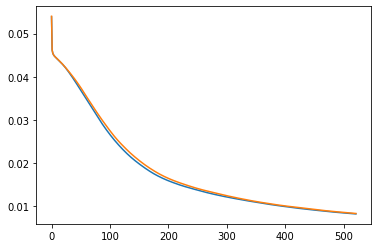

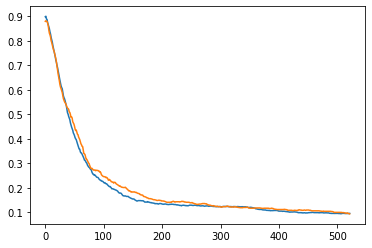

In [42]:
  train_err, test_err = np.array(opt.train_err), np.array(opt.test_err)

  print(test_err[-1,1])

  plt.plot(train_err[:,0])
  plt.plot(test_err[:,0])
  plt.show()

  plt.plot(train_err[:,1])
  plt.plot(test_err[:,1])
  plt.show()

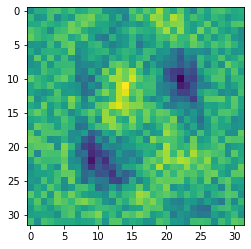

In [43]:
  plt.imshow(best_nnet.layer[1].W[0,1:].reshape(32,32))

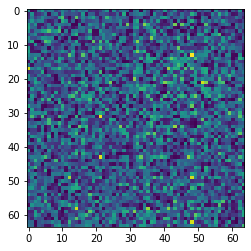

In [44]:
  plt.imshow(np.absolute(best_nnet.layer[2].W[:,1:]))